In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import torchvision
from torch.utils.data import TensorDataset, DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')
datapath = f'/content/drive/MyDrive/PW/NN/Data/Alz_Full/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Data Load and Preprocessing

In [4]:
mode = 'minmax'
# mode = 'zscore'

MODEL_PATH = f'/content/drive/MyDrive/PW/NN/alz_resnet18_{mode}.pt'

# Notion
fn = datapath+f'{mode}_train.npy'
with open(fn, 'rb') as f:
    df_train = np.load(f)


fn = datapath+f'{mode}_test.npy'
with open(fn, 'rb') as f:
    df_test = np.load(f)

df_train.shape, df_test.shape

((5121, 3, 208, 176), (1096, 3, 208, 176))

In [5]:
df_train[1,:].mean()

-0.3581318280113461

## Data to Tensor

In [6]:
X_train = torch.from_numpy(df_train)
X_test = torch.from_numpy(df_test)
X_train.shape, X_test.shape

(torch.Size([5121, 3, 208, 176]), torch.Size([1096, 3, 208, 176]))

In [7]:
# ask AOK about class balance

TRAIN_SIZE_0 = 2560
TRAIN_SIZE_1 = 2561

target_train = np.zeros((TRAIN_SIZE_0+TRAIN_SIZE_1, 1))
target_train[TRAIN_SIZE_0:] = np.ones((TRAIN_SIZE_1, 1))
target_train = torch.from_numpy(target_train)
target_train.shape

torch.Size([5121, 1])

In [8]:
TEST_SIZE_0 = 640
TEST_SIZE_1 = 456

target_test = np.zeros((TEST_SIZE_0+TEST_SIZE_1, 1))
target_test[TEST_SIZE_0:] = np.ones((TEST_SIZE_1, 1))
target_test = torch.from_numpy(target_test)
target_test.shape

torch.Size([1096, 1])

## DataLoader

In [9]:
train_dataset = TensorDataset(X_train, target_train)
test_dataset = TensorDataset(X_test, target_test)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=2)
dataloaders = {'train': train_loader, 'test': test_loader}

In [10]:
class_names = ['NonDemented', 'Demented']

dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}
dataset_sizes

{'test': 1096, 'train': 5121}

## Visualizing

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    with plt.style.context('dark_background'):
        inp = inp.cpu().detach().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        plt.figure(figsize=(25, 5), dpi=100)
        plt.imshow(inp)
        plt.axis('off')
        if title is not None:
            for i in range(len(title)):
                
                plt.text(10+177*i, 17, title[i], color='cyan', fontsize=12) #, bbox=dict(fill=False, edgecolor='cyan', linewidth=2))
            # plt.title(title)
        plt.pause(0.001)  # pause a bit so that plots are updated

# Make a grid from batch
def show_grid( inputs, classes, sup=None ):
    out = torchvision.utils.make_grid(inputs)
    # imshow(out, title=f'{sup} {[int(x) for x in classes]}')
    imshow(out, title=[f'{sup}: {int(x)}' for x in classes])

In [12]:
# Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))
# show_grid( inputs, classes )

# The  Model

## ResNet18

In [13]:
model_ft = torchvision.models.resnet18(pretrained=True)
# print(model_ft)

In [14]:
len(list(model_ft.parameters()))

62

In [15]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device) #, dtype=torch.double)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [16]:
num_ftrs

512

## Continue Training the Transfered Model

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device).type(torch.float)

                # Notion
                labels = labels.to(device).type(torch.long)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # print(outputs, '\n', labels)
                    # print(outputs.shape, '\n', labels.shape)
                    labels = labels.squeeze(-1)
                    # print(labels.shape)
                    loss = criterion(outputs, labels)
                    # loss = criterion(outputs, torch.max(labels, 1)[1])

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [18]:
# # Train a new model
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)
# torch.save(model_ft.state_dict(), MODEL_PATH)

## or, Loading Existing Model

In [19]:
model_ft.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

# The Results

### Evaluation

In [20]:
import sklearn.metrics as metrics

In [40]:
def test_forward( model, inputs ):
    inputs = inputs.to(device).type(torch.float)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    
    true_classes = classes.reshape((1,596)).tolist()[0]
    predicted_classes = preds.tolist()
    
    cm = metrics.confusion_matrix( true_classes, predicted_classes, labels=[0,1] )
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    with plt.style.context('dark_background'):
        disp.plot()
    
    print(f'Precision: {round(metrics.precision_score(true_classes, predicted_classes),2)}')
    print(f'Recall: {round(metrics.recall_score(true_classes, predicted_classes),2)}')
    print(f'F1 score: {round(metrics.f1_score(true_classes, predicted_classes),2)}')

    return preds

In [41]:
target_test.shape

torch.Size([1096, 1])

In [42]:
inputs = X_test[500:]
classes = target_test[500:]
# inputs, classes = next(iter(test_loader))
inputs = inputs.to(device).type(torch.float)
classes = classes.to(device).type(torch.long)
print(classes.shape)

torch.Size([596, 1])


Precision: 0.93
Recall: 0.78
F1 score: 0.85


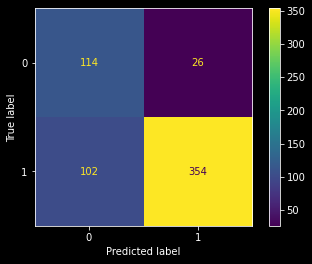

In [43]:
# Confusion Matrix  
preds = test_forward( model_ft, inputs )

### Visualization

In [47]:
inputs, classes = next(iter(test_loader))
inputs = inputs.to(device).type(torch.float)
classes = classes.to(device).type(torch.long)

outputs = model_ft(inputs)
_, preds = torch.max(outputs, 1)

print(inputs.shape)

torch.Size([4, 3, 208, 176])


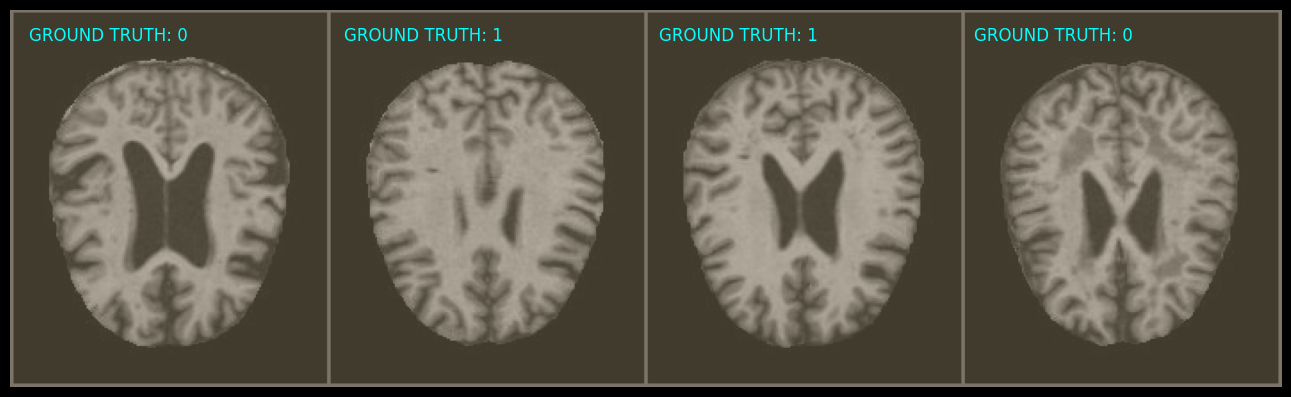

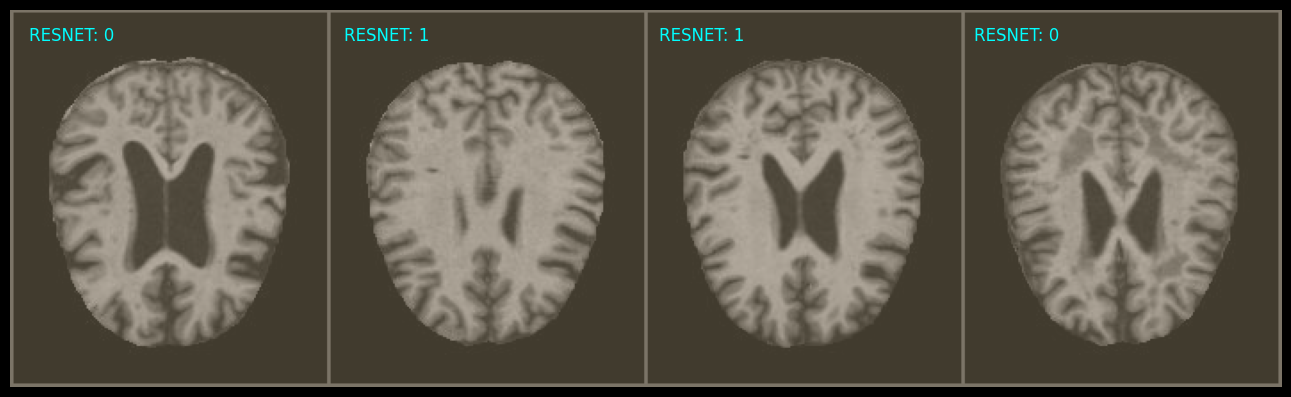

In [48]:
show_grid( inputs, classes, sup='GROUND TRUTH' )
show_grid( inputs, preds, sup='RESNET' )

# Grad CAM

## Folders and Imports

In [27]:
import sys
sys.path.append('/content/drive/MyDrive/PW/NN/')
sys.path.append('/content/drive/MyDrive/PW/NN/pytorch_grad_cam/')
sys.path.append('/content/drive/MyDrive/PW/NN/pytorch_grad_cam/pytorch_grad_cam/')
sys.path.append('/content/drive/MyDrive/PW/NN/pytorch_grad_cam/pytorch_grad_cam/grad_cam/')
# something from this works...

In [28]:
print(sys.path[::-1])

['/content/drive/MyDrive/PW/NN/pytorch_grad_cam/pytorch_grad_cam/grad_cam/', '/content/drive/MyDrive/PW/NN/pytorch_grad_cam/pytorch_grad_cam/', '/content/drive/MyDrive/PW/NN/pytorch_grad_cam/', '/content/drive/MyDrive/PW/NN/', '/root/.ipython', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3.7/lib-dynload', '/usr/lib/python3.7', '/usr/lib/python37.zip', '/env/python', '/content', '']


In [29]:
%cd /content/drive/MyDrive/PW/NN/

/content/drive/MyDrive/PW/NN


In [30]:
# pytorch_grad_cam is a renamed repo (originally pytorch-grad-cam)
!ls

 Alz_Exploration.ipynb	       myfold
 Alz_Exp_old.ipynb	       myfun.py
 alz_resnet18_minmax.pt        __pycache__
 alz_resnet18.pt	       pytorch_grad_cam
 Alz_Transfer.ipynb	       RBF_Test.ipynb
'Copy of Alz_Transfer.ipynb'  'TONOTION Haidukevich_Pytorch.ipynb'
 Data			       Transfer_Test.ipynb


In [31]:
!pip install ttach

In [32]:
from pytorch_grad_cam.grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

## GradCAM on Layer4

In [33]:
# print( model_ft.layer4 )

In [34]:
target_layers = [model_ft.layer4[-1]]
cam = GradCAM(model=model_ft, target_layers=target_layers, use_cuda=True)
targets = [ClassifierOutputTarget(1)]

In [35]:
inputs.shape

torch.Size([4, 3, 208, 176])

In [36]:
def grad_cam_test( inp ):
    
    BS = inp.shape[0]
    inp = torch.cat((inp[0].unsqueeze(0), inp), 0)
    inp = inp.to(device).type(torch.float)

    grayscale_cam = cam(input_tensor=inp, targets=targets, aug_smooth=True, eigen_smooth=True)

    with plt.style.context('dark_background'):
        fig, ax = plt.subplots(1, BS, figsize=(18, 6), dpi=100)

        for i in range(BS):

            img = inp[i].cpu().detach().numpy().transpose((1,2,0))
            img = np.float32(img)
            img = cv2.cvtColor(img, cv2.CV_8U)[:,:,:3]

            visualization = show_cam_on_image(img, grayscale_cam[i+1, :], use_rgb=True) 

            ax[i].set_title( f'{classes[i][0]}/{preds[i]}' )
            ax[i].imshow(visualization)

        fig.tight_layout()
        fig.suptitle('CLASS / PREDICTION')


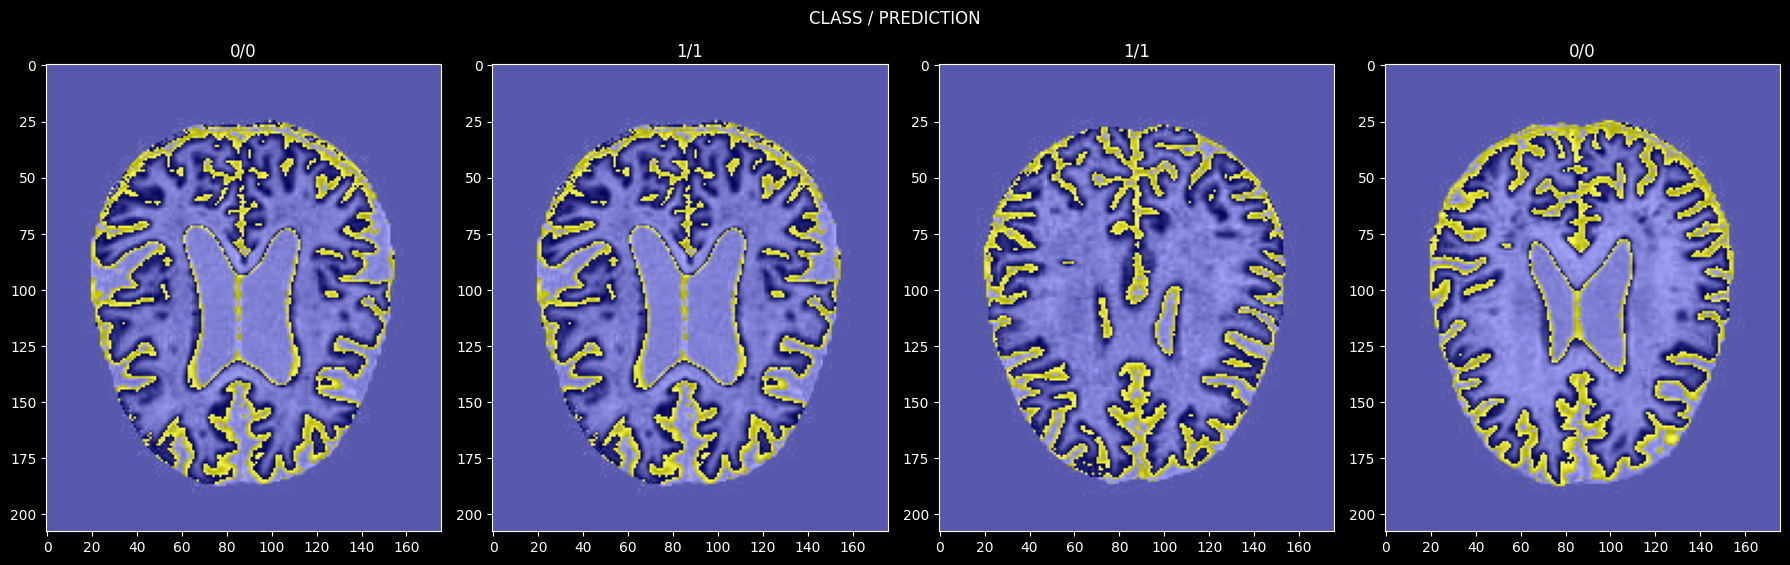

In [49]:
grad_cam_test( inputs )